# Position of the Telescope in the Dome

In [1]:
%matplotlib notebook
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

## Modelling The Telescope Pointing

Relevant dimensions/constants:

In [2]:
l_1 = 2 # meters
l_2 = 2 # meters
l_3 = 1 # meters
lat = 53.24 # degrees

Defining the transformation matrices:

In [3]:
def vec(x, y, z):
    return np.array([x, y, z, 1]).reshape((4,1))

def trans(x, y, z):
    return np.array([
        [1, 0, 0, x],
        [0, 1, 0, y],
        [0, 0, 1, z],
        [0, 0, 0, 1],
    ])

def rot_x(angle):
    angle = np.radians(angle)
    return np.array([
        [1,             0,              0, 0],
        [0, np.cos(angle), -np.sin(angle), 0],
        [0, np.sin(angle),  np.cos(angle), 0],
        [0,             0,              0, 1],
    ])

def rot_y(angle):
    angle = np.radians(angle)
    return np.array([
        [np.cos(angle),  0,  -np.sin(angle), 0],
        [0,              1,               0, 0],
        [-np.sin(angle), 0,   np.cos(angle), 0],
        [0,              0,               0, 1],
    ])

def rot_z(angle):
    angle = np.radians(angle)
    return np.array([
        [np.cos(angle),  -np.sin(angle), 0, 0],
        [np.sin(angle),  np.cos(angle), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ])

Compute the position of the telescope back plate with `get_transform` and `telescope_pos`.

In [4]:
def get_transform(ha, dec, y_back=-0.5):
    H_01 = trans(0, 0, l_1)
    H_12 = rot_x(lat) @ rot_z(ha) @ trans(0, 0, l_2)
    H_23 = rot_x(dec) @ trans(-l_3, 0, 0)
    H_34 = trans(0, y_back, 0)
    
    H = H_01 @ H_12 @ H_23 @ H_34
    
    return H

def telescope_pos(ha=0, dec=0):
    origin = vec(0, 0, 0)
    print(ha, dec)
    pose_matrix = get_transform(ha, dec)
    
    return pose_matrix @ origin

## Telescope in dome frame

Compute the origin of each consecutive reference frame with `get_origins`.

In [5]:
def get_origins(ha, dec, y_back=-0.5):
    """Compute the origin of each intermediate ref. frame."""
    origin = vec(0, 0, 0)
    H_01 = trans(0, 0, l_1)
    H_12 = rot_x(lat) @ rot_z(ha) @ trans(0, 0, l_2)
    H_23 = rot_x(dec) @ trans(-l_3, 0, 0)
    H_34 = trans(0, y_back, 0)
    H_45 = trans(0, -3*y_back, 0)
    
    pose_0 = origin
    pose_1 = H_01 @ origin
    pose_2 = H_01 @ H_12 @ origin
    pose_3 = H_01 @ H_12 @ H_23 @ origin
    pose_4 = H_01 @ H_12 @ H_23 @ H_34 @ origin
    pose_5 = H_01 @ H_12 @ H_23 @ H_34 @ H_45 @ origin

    return np.array([pose_0, pose_1,pose_2,pose_3,pose_4, pose_5])

(Interactivelly) plot the resulting *telescope + mount* assembly.

<IPython.core.display.Javascript object>


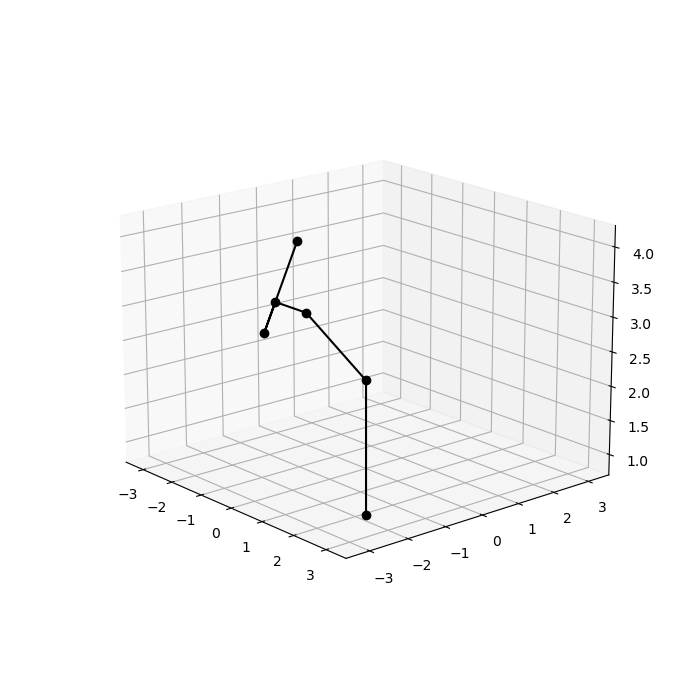

interactive(children=(FloatSlider(value=0.0, description='ha', max=360.0, step=0.5), FloatSlider(value=0.0, de…

In [6]:
fig = plt.figure(figsize=(7, 7))
frame = fig.add_subplot(1, 1, 1, projection ='3d')

frame.grid(True, alpha=0.5)
frame.set_xlim(-5, 5)
frame.set_ylim(-5, 5)
frame.set_zlim(0, 5)

@widgets.interact(ha=(0, 360, 0.5), dec=(-90, 90, 0.5))
def update(ha = 0, dec=0):
    [l.remove() for l in frame.lines]
    
    # Get the origins of each ref. frame 
    os = get_origins(ha, dec)[:,:3].reshape(6, 3)
    
    frame.plot3D(os[:,0], os[:,1], os[:,2], marker='o', color='black')

## Polar graph

In [7]:
# fig, frame = plt.subplots(subplot_kw={'projection': 'polar'})
# r = np.arange(0, 2, 0.01)

# # ax.set_rmax(5)
# frame.grid(True)
# frame.set_theta_zero_location("N")

# frame.scatter(np.pi/2, 1)

# frame.set_title("A line plot on a polar axis", va='bottom')
# plt.show()

## Computing the LST and HA

In [8]:
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy import units as u
import datetime

observing_location = EarthLocation(lat=53.240243*u.deg, lon=6.53651*u.deg)
observing_time = Time(datetime.datetime.utcnow(), scale='utc', location=observing_location)
lst = observing_time.sidereal_time('mean')

In [9]:
lst

<Longitude 23.79600666 hourangle>

In [10]:
lst.hour

23.796006658960884

In [11]:
lst.rad

6.229779975380442

In [12]:
lst.deg

356.9400998844132